In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
airline_df = pd.read_csv('data\\raw\\airlines.csv')
airline_df.sample(5)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
10,EV,Atlantic Southeast Airlines
6,AS,Alaska Airlines Inc.
9,DL,Delta Air Lines Inc.
4,B6,JetBlue Airways


In [45]:
airport_df = pd.read_csv('data\\raw\\airports.csv')
airport_df.sample(5)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
137,GUM,Guam International Airport,Agana,GU,USA,13.48345,-144.79598
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN
276,SDF,Louisville International Airport (Standiford F...,Louisville,KY,USA,38.17439,-85.73600
57,CEC,Del Norte County Airport (Jack McNamara Field),Crescent City,CA,USA,41.78016,-124.23653
290,SPI,Abraham Lincoln Capital Airport,Springfield,IL,USA,39.84395,-89.67762


In [46]:
flight_df = pd.read_csv('data\\raw\\flights.csv')
flight_df.sample(5)

C:\Users\user\AppData\Local\Temp\ipykernel_11316\2406861582.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_df = pd.read_csv('data\\raw\\flights.csv')


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
5224105,2015,11,23,1,AS,182,N799AS,ANC,SEA,1100,...,1506.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2326283,2015,5,28,4,UA,1176,N75851,LAX,OGG,920,...,1151.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
222819,2015,1,15,4,WN,515,N612SW,MSY,ATL,1235,...,1448.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1486936,2015,4,6,1,UA,607,N821UA,DCA,ORD,845,...,948.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
206826,2015,1,14,3,DL,2014,N967AT,DTW,BNA,1215,...,1308.0,-4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
cancel_flight_df = flight_df[['CANCELLED', 'CANCELLATION_REASON']]
flight_df.drop(columns=['CANCELLED', 'CANCELLATION_REASON'], inplace=True)
cancel_flight_df.sample(5)

,CANCELLED,CANCELLATION_REASON
4171912,0,NaN
4624328,0,NaN
3121157,0,NaN
1868014,0,NaN
4042867,0,NaN


In [48]:
flight_df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
       'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [49]:
delay_cols = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

In [50]:
flight_df['DELAY'] = flight_df['AIR_SYSTEM_DELAY'].astype('Int16') + flight_df['SECURITY_DELAY'].astype('Int16') + flight_df['AIRLINE_DELAY'].astype('Int16') + flight_df['LATE_AIRCRAFT_DELAY'].astype('Int16') + flight_df['WEATHER_DELAY'].astype('Int16')
# flight_df['DELAY'] = flight_df['DELAY'].fillna(0).astype('Int16')

In [51]:
flight_df['FLIGHT_NUMBER'].corr(flight_df['DELAY'])

np.float64(0.01515487111261943)

In [52]:
flight_df.drop('FLIGHT_NUMBER', axis=1, inplace=True)

In [53]:
flight_df[delay_cols].corrwith(flight_df['DIVERTED']).sort_values(ascending=False)

c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


AIR_SYSTEM_DELAY      NaN
SECURITY_DELAY        NaN
AIRLINE_DELAY         NaN
LATE_AIRCRAFT_DELAY   NaN
WEATHER_DELAY         NaN
dtype: float64

In [54]:
flight_df.DIVERTED.unique()

array([0, 1])

In [58]:
cat_col = ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
for i in cat_col:
    flight_df[i] = flight_df[i].astype('category')
    flight_df[f'{i}_CODE'] = flight_df[i].cat.codes  # -1 means NaN

In [61]:
flight_df['ROUTE_CODE'] = flight_df['ORIGIN_AIRPORT'].astype(str) + '-' + flight_df['DESTINATION_AIRPORT'].astype(str)
flight_df['ROUTE_CODE'] = flight_df['ROUTE_CODE'].astype('category')
flight_df['ROUTE_CODE'] = flight_df['ROUTE_CODE'].cat.codes  # -1 means NaN

In [62]:
flight_df.sample(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAY,AIRLINE_CODE,TAIL_NUMBER_CODE,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,ROUTE_CODE
1846791,2015,4,28,2,WN,N723SW,DTW,MDW,1310,1307.0,...,NaN,NaN,NaN,NaN,<NA>,13,3268,701,803,5350
4234837,2015,9,21,1,AA,N852AA,DFW,LAS,1230,1226.0,...,NaN,NaN,NaN,NaN,<NA>,0,4104,694,782,5188
1728287,2015,4,21,2,OO,N442SW,GRR,CVG,729,723.0,...,NaN,NaN,NaN,NaN,<NA>,9,1731,738,686,5687
3060152,2015,7,11,6,DL,N314NB,ATL,CMH,1050,1048.0,...,NaN,NaN,NaN,NaN,<NA>,3,889,628,675,4061
3608060,2015,8,12,3,B6,N508JB,LGB,LAS,1800,1846.0,...,0.0,22.0,15.0,0.0,37,2,2035,791,782,6508


In [63]:
flight_df.drop(columns=['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace=True)

<Axes: >

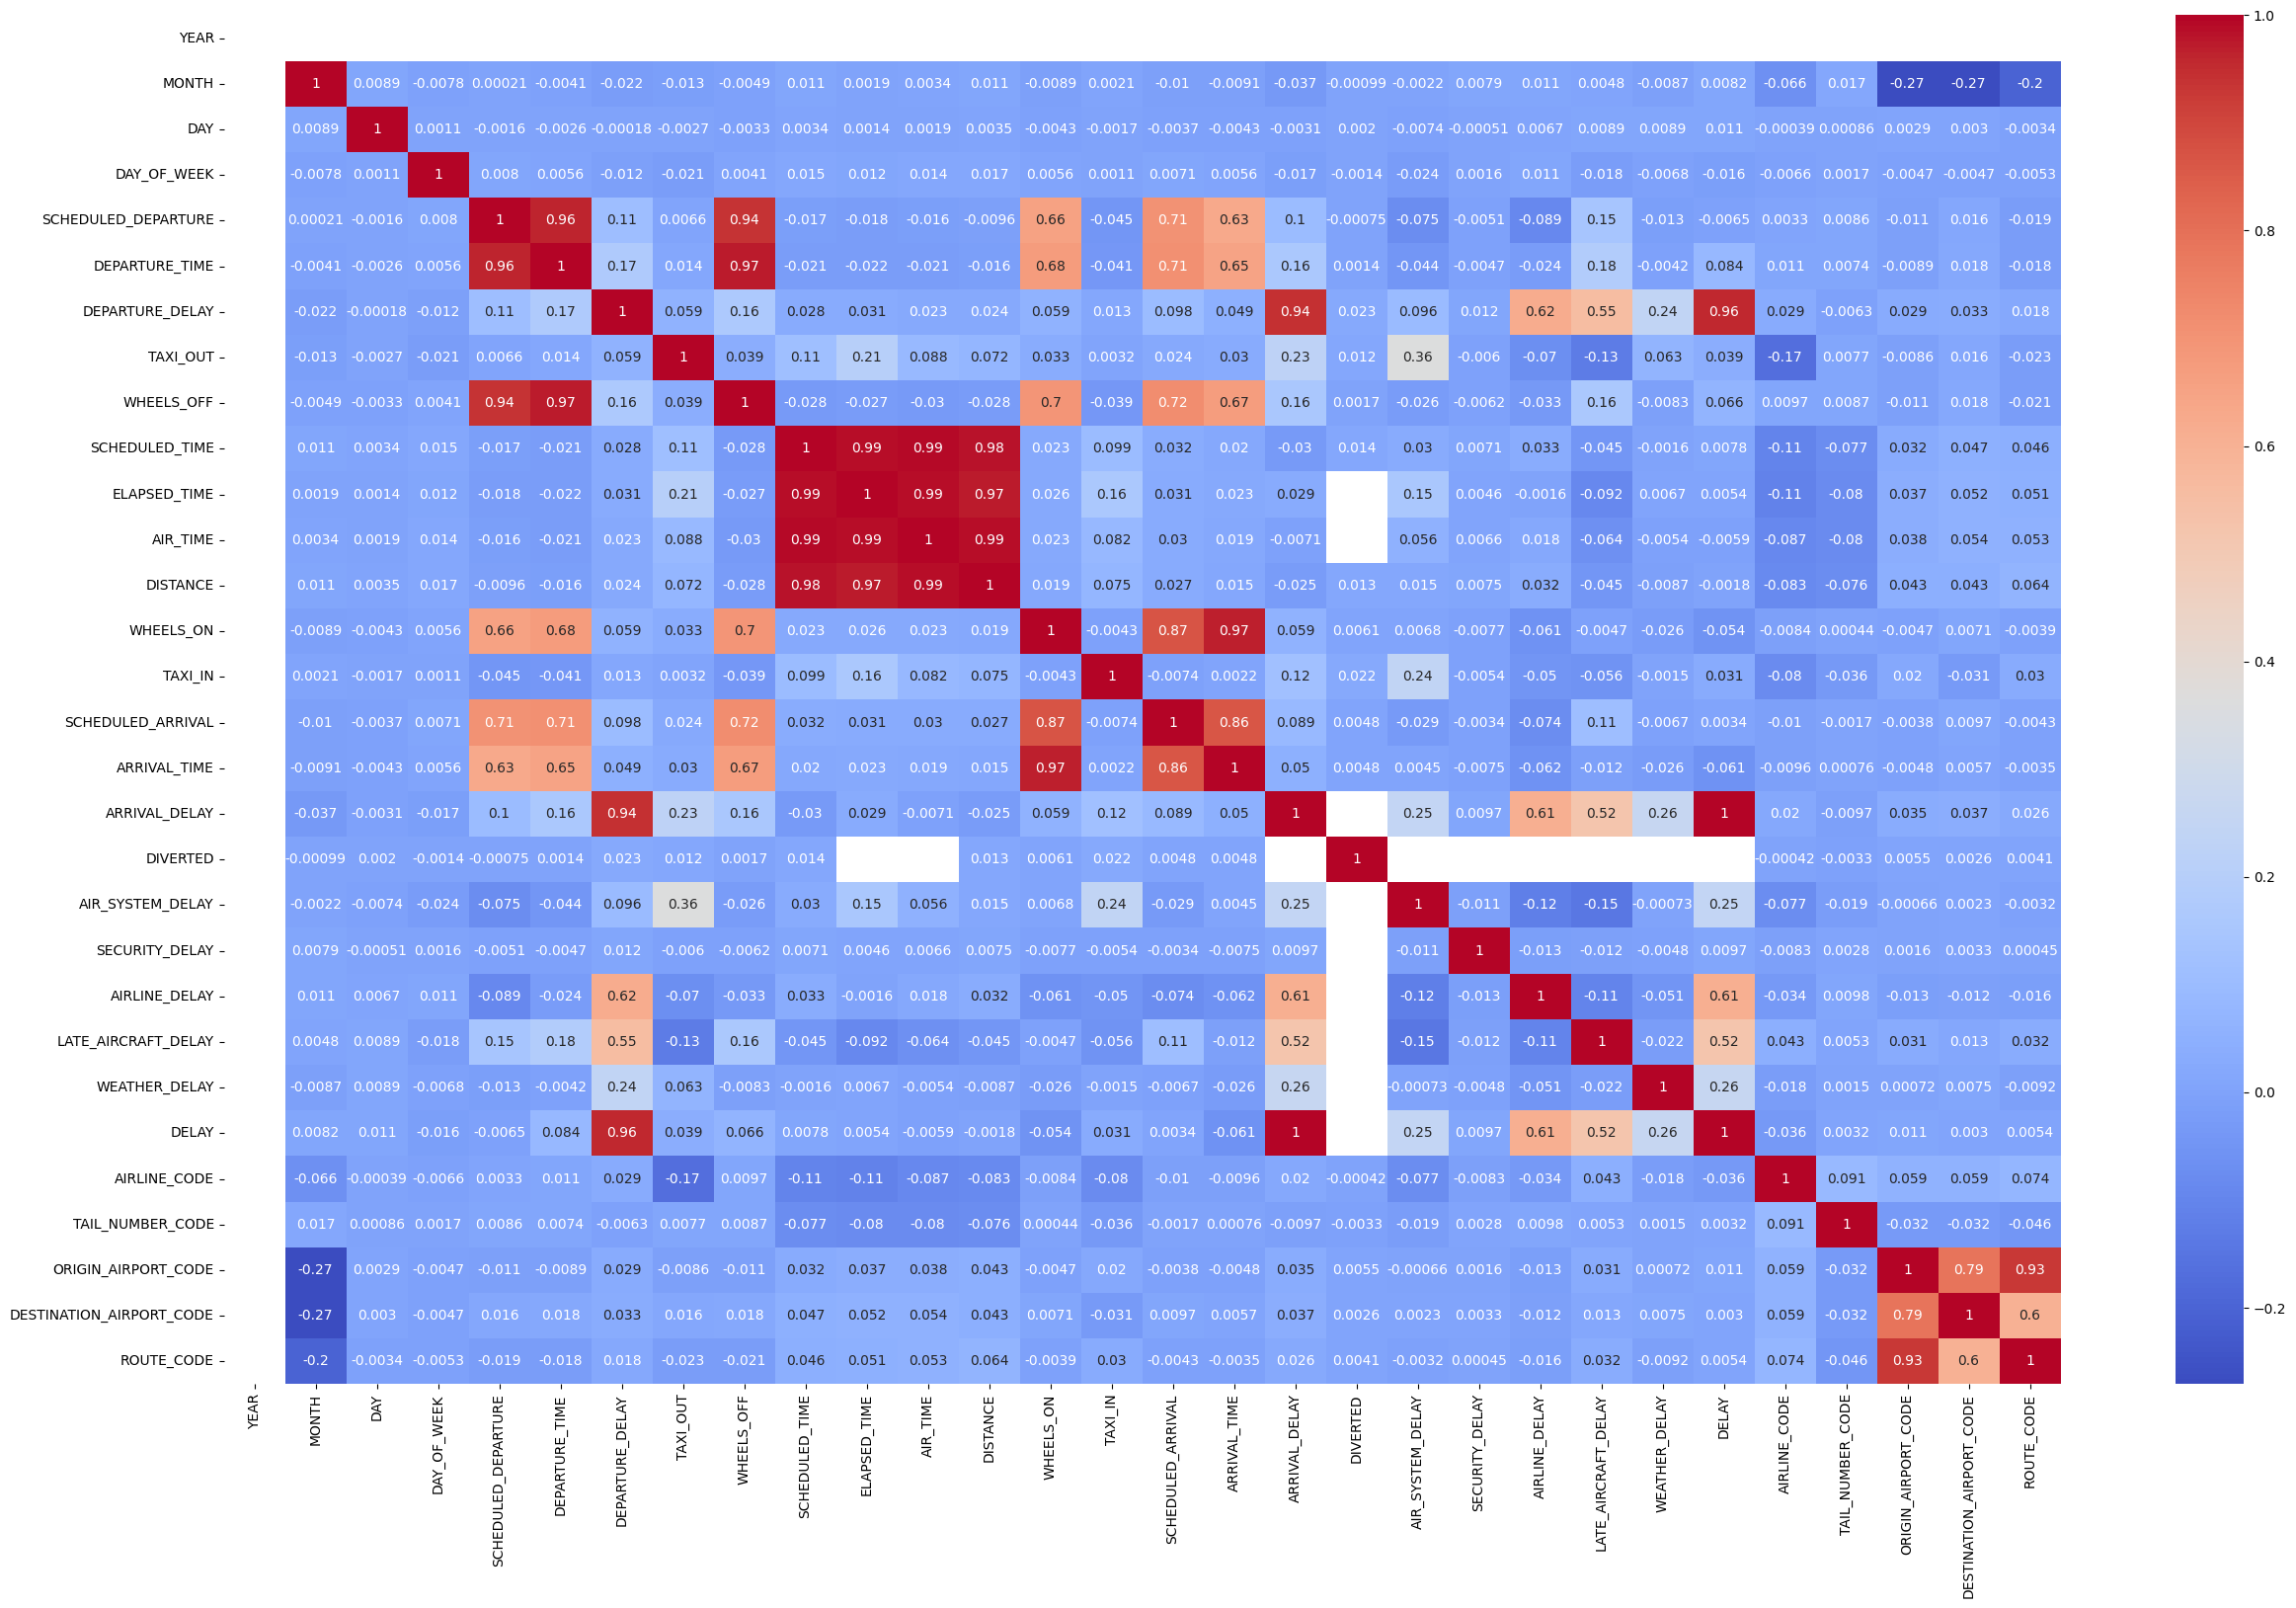

In [64]:
plt.figure(figsize=(30,18))
sns.heatmap(flight_df.corr(), annot=True, cmap='coolwarm')

# no correlation so no model